In [18]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.signal import stft
import matplotlib.pyplot as plt
from neurodsp.utils import create_times

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 샘플 데이터 생성
fpath = "../../data/DNN_data/v3/"

sig_with_artifact = np.load(fpath + "data_with_artifact_test" + ".npy")
sig = np.load(fpath + "data_signal" + ".npy")
artifact = sig_with_artifact - sig

x_data = sig_with_artifact
y_data = sig

print(x_data.shape)
print(y_data.shape)

cuda:0
(1000, 4000)
(1000, 4000)


In [19]:
fs = 2000
num_signals = 1000
n_seconds = 2
times = create_times(n_seconds, fs)

fft_win_time = 0.5  # 윈도우 길이 (초)
n_fft = int(fft_win_time * fs)  # FFT 윈도우 크기, 1000 샘플
fft_overlap_time = int(fft_win_time / 2 * fs)  # 오버랩 크기, 500 샘플, 50%
freqs = torch.fft.rfftfreq(n_fft, 1 / fs) # 주파수 대역

In [20]:
# stft
x_stft = []
x_stft_2 =[]
def compute_stft(data, fs, fft_win_time):
    n_fft = int(fft_win_time * fs)
    fft_overlap_time = int(fft_win_time / 2 * fs)
    
    stft_results = []
    for sample in data:
        # torch.tensor로 변환할 때 dtype=torch.float32로 명시적으로 지정
        sample_tensor = torch.tensor(sample, dtype=torch.float32)
        Zxx = torch.stft(sample_tensor, n_fft, hop_length=n_fft - fft_overlap_time, return_complex=True)
        stft_results.append(Zxx)

    # 넘파이 배열로 변환
    stft_results_np = np.array(stft_results)
    
    return stft_results_np

x_stft = compute_stft(x_data, fs, fft_win_time)
y_stft = compute_stft(y_data, fs, fft_win_time)

# print(f"x_data shape: {x_data.shape}") # (1000, 4000)
# print(f"x_stft shape: {x_stft.shape}") # (1000, 501, 9)
# print(f"x_stft_2 shape: {x_stft_2.shape}") # (1000, 501, 9, 2)
# print(f"y_data shape: {y_data.shape}") # (1000, 4000)
# print(f"y_stft shape: {y_stft.shape}") # (1000, 501, 9)

print(f"x_stft: {x_stft[0][0]}")
print(f"y_stft: {y_stft[0][0][0]}")

# 각 요소는 (frequency_bins, time_frames, 2)의 복소수(2; 실수, 허수 성분) 텐서입니다.
# x_data[0] shape: (4000,)
# x_stft[0] shape: (1000, 501, 9)

# log10 씌워주기
x_stft = np.log10(np.abs(x_stft)**2 + 1e-6)
y_stft = np.log10(np.abs(y_stft)**2 + 1e-6)

x_stft: [  505.7691 +0.j  1306.8297 +0.j  1027.0393 +0.j  -143.7783 +0.j
   157.88266+0.j   435.17474+0.j   282.8852 +0.j  -930.9418 +0.j
 -2116.931  +0.j]
y_stft: (-3.471951484680176+0j)


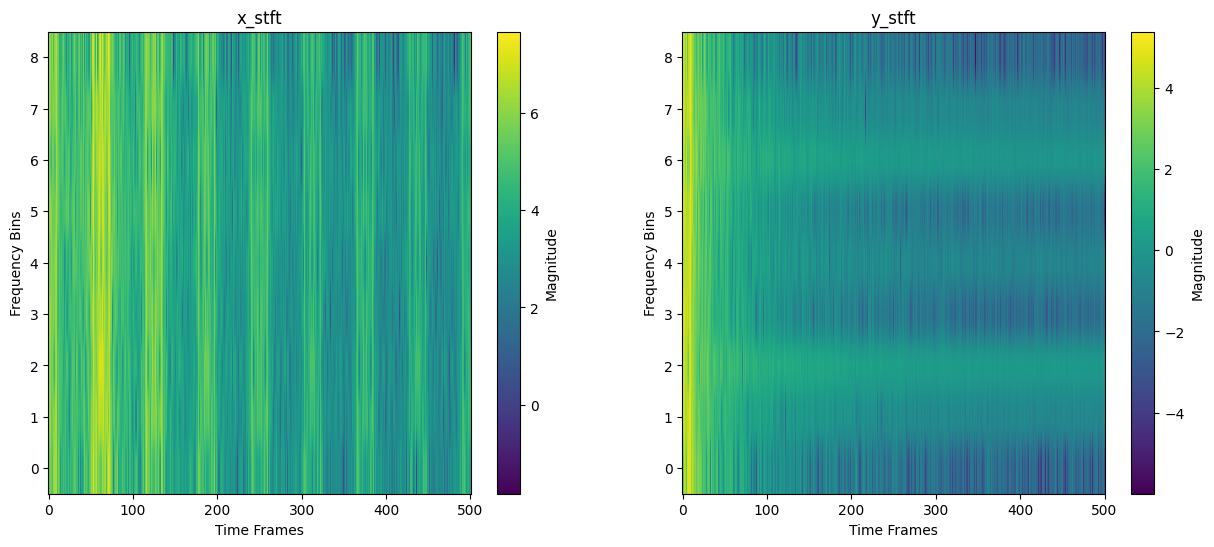

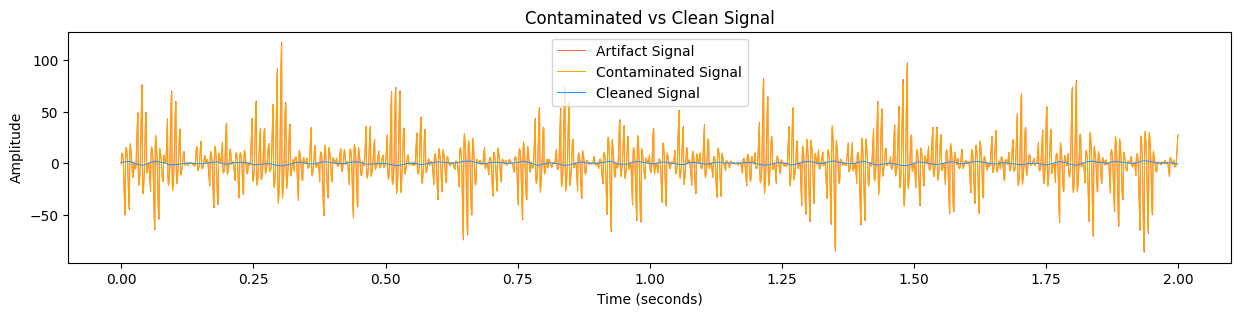

<Figure size 640x480 with 0 Axes>

In [21]:
# 2D spectrogram
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(x_stft[0, :, :].real.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('x_stft')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.subplot(1, 2, 2)
plt.imshow(y_stft[0, :, :].real.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('y_stft')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.figure(figsize=(15, 3))
plt.plot(times, artifact[0], label='Artifact Signal', color='tomato', alpha=1, linewidth=0.7)
plt.plot(times, sig_with_artifact[0], label='Contaminated Signal', color='orange', alpha=1, linewidth=0.7)
plt.plot(times, sig[0], label='Cleaned Signal', color='dodgerblue', alpha=1, linewidth=0.7)
plt.xlabel('Time (seconds)');plt.ylabel('Amplitude');plt.title('Contaminated vs Clean Signal');plt.legend();plt.show()

plt.tight_layout()
plt.show()


In [22]:
# # power spectrum
# power_spectrum = np.abs(Zxx) ** 2  # 파워 스펙트럼 계산

In [23]:
# scaler = StandardScaler()
# scaler = MinMaxScaler()

# X = scaler.fit_transform(x_stft.T)
# Y = (y_stft.T-scaler.mean_)/np.sqrt(scaler.var_) # X와 동일한 평균, 표준 편차로 scaling

# X = X.T
# Y = Y.T

# print(X.shape)
# print(Y.shape) 

In [24]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(x_stft, y_stft, test_size=0.2, random_state=42)

# 데이터를 3채널로 변환
X_train = np.repeat(X_train[:, np.newaxis, :, :], 3, axis=1)
X_test = np.repeat(X_test[:, np.newaxis, :, :], 3, axis=1)
y_train = np.repeat(y_train[:, np.newaxis, :, :], 3, axis=1)
y_test = np.repeat(y_test[:, np.newaxis, :, :], 3, axis=1)

# 데이터 타입 변경 및 로그 변환
X_train = torch.log10(torch.abs(torch.tensor(X_train, dtype=torch.float32))**2 + 1e-6)
X_test = torch.log10(torch.abs(torch.tensor(X_test, dtype=torch.float32))**2 + 1e-6)
y_train = torch.log10(torch.abs(torch.tensor(y_train, dtype=torch.float32))**2 + 1e-6)
y_test = torch.log10(torch.abs(torch.tensor(y_test, dtype=torch.float32))**2 + 1e-6)

print("변환된 X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape))
print("변환된 X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

# TensorDataset 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# DataLoader 생성
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# 배치 형태 확인
for batch in train_loader:
    inputs, targets = batch
    print("배치 입력 shape:", inputs.shape)
    print("배치 타겟 shape:", targets.shape)
    break  # 첫 번째 배치만 확인

변환된 X_train shape: torch.Size([800, 3, 501, 9]), y_train shape: torch.Size([800, 3, 501, 9])
변환된 X_test shape: torch.Size([200, 3, 501, 9]), y_test shape: torch.Size([200, 3, 501, 9])
배치 입력 shape: torch.Size([32, 3, 501, 9])
배치 타겟 shape: torch.Size([32, 3, 501, 9])


In [25]:
# 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=(3, 3), stride=1, padding="same")
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=3, kernel_size=(3, 3), stride=1, padding="same")
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.gelu(x)
        x = self.conv2(x)
        x = self.gelu(x)
        return x

model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(24, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (gelu): GELU(approximate='none')
)


In [26]:
# 모델 훈련
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 200

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0] # x : B x 3 x F x T
        y = batch[1] # y : B x 3 x F x T
        x, y = x.to(device), y.to(device)
        # x, y = x.type(torch.float32), y.type(torch.float32)
        # x, y = torch.log10(torch.abs(x)**2 + 1e-6), torch.log10(torch.abs(y)**2 + 1e-6)
        
        y_pred = model(x) # y_pred : B x F x T
        loss = criterion(y_pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 5/200, Loss: 1.191623568534851
Epoch 10/200, Loss: 1.1140040159225464
Epoch 15/200, Loss: 1.0796061754226685
Epoch 20/200, Loss: 1.1518088579177856
Epoch 25/200, Loss: 1.1569486856460571
Epoch 30/200, Loss: 1.1615426540374756
Epoch 35/200, Loss: 1.1746143102645874
Epoch 40/200, Loss: 1.1800439357757568
Epoch 45/200, Loss: 1.1475411653518677
Epoch 50/200, Loss: 1.200590968132019
Epoch 55/200, Loss: 1.2579139471054077
Epoch 60/200, Loss: 1.26704740524292
Epoch 65/200, Loss: 1.202540397644043
Epoch 70/200, Loss: 1.2112973928451538
Epoch 75/200, Loss: 1.1426125764846802
Epoch 80/200, Loss: 1.202268362045288
Epoch 85/200, Loss: 1.141470193862915
Epoch 90/200, Loss: 1.2224721908569336
Epoch 95/200, Loss: 1.1004600524902344
Epoch 100/200, Loss: 1.2100346088409424
Epoch 105/200, Loss: 1.2003017663955688
Epoch 110/200, Loss: 1.1268364191055298
Epoch 115/200, Loss: 1.167588710784912
Epoch 120/200, Loss: 1.202194333076477
Epoch 125/200, Loss: 1.126422643661499
Epoch 130/200, Loss: 1.1795114

In [27]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x 1 x F x T
        y = batch[1] # y : B x 1 x F x T 
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x 1 x F x T
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.cpu()), 0)
        Clean = torch.cat((Clean, y.cpu()), 0)

val_loss = criterion(Clean, SACed)
print(f'Validation Loss: {val_loss.item()}')    

Validation Loss: 1.1491948366165161


In [29]:
print(f"Contaminated shape: {Contaminated.shape}") # 
print(f"Clean shape: {Clean.shape}") #
print(f"SACed shape: {SACed.shape}") # 

Contaminated shape: torch.Size([200, 3, 501, 9])
Clean shape: torch.Size([200, 3, 501, 9])
SACed shape: torch.Size([200, 3, 501, 9])


C:\Users\stell\AppData\Local\Temp\ipykernel_12164\408966724.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3701.)
  plt.imshow(Contaminated[0, :, :].real.T, aspect='auto', origin='lower', cmap='viridis')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3626244..1.7712616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.97973..1.5542921].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16997123..1.5247989].


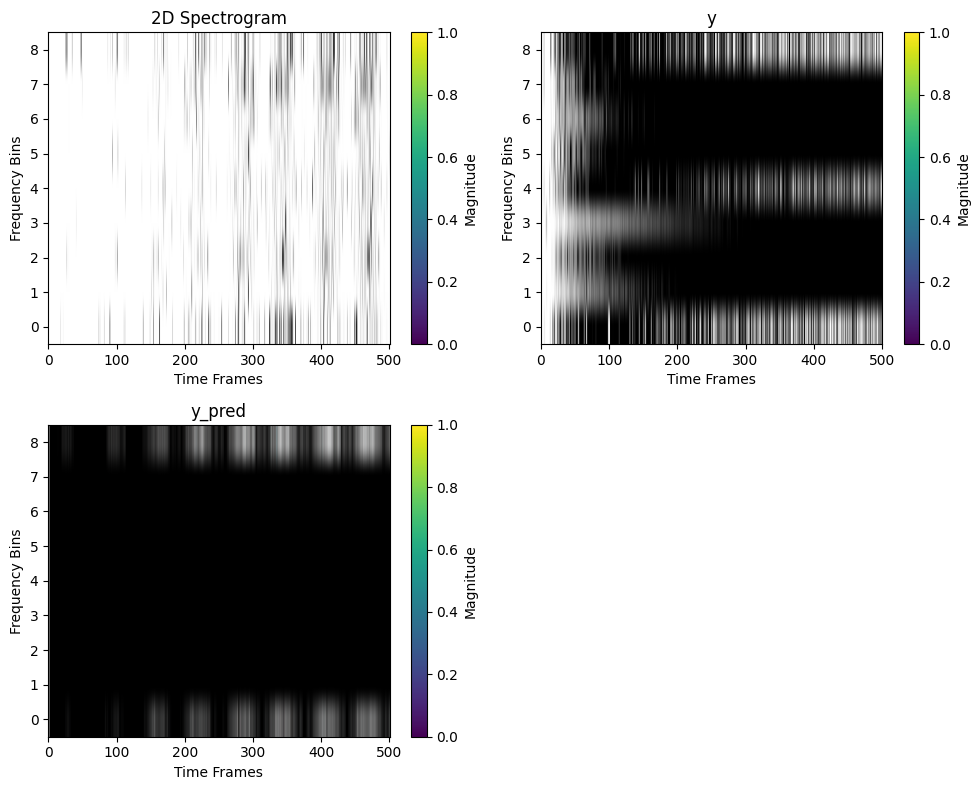

In [28]:
# 2D spectrogram
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(Contaminated[0, :, :].real.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('2D Spectrogram')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.subplot(2, 2, 2)
plt.imshow(Clean[0, :, :].real.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('y')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.subplot(2, 2, 3)
plt.imshow(SACed[0, :, :].real.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.title('y_pred')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3626244..1.7712616].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.97973..1.5542921].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16997123..1.5247989].


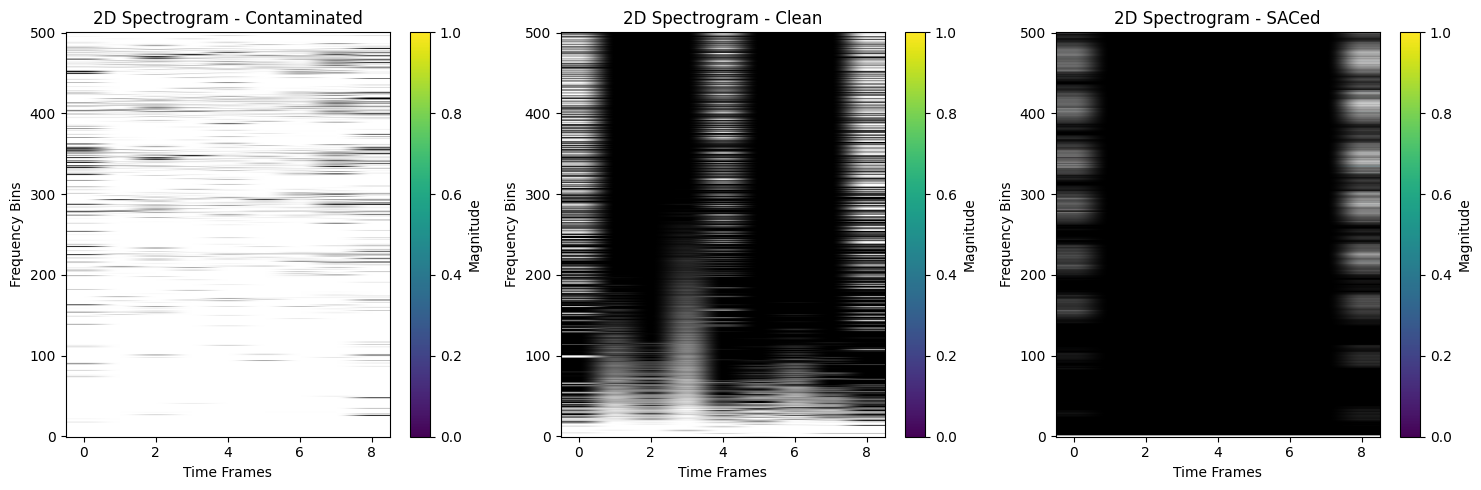

In [31]:
#test

# 첫 번째 샘플의 데이터를 시각화
sample_index = 0

# 첫 번째 샘플의 3채널 데이터를 시각화
contaminated_sample = Contaminated[sample_index, :, :, :].permute(1, 2, 0)  # (501, 9, 3)
clean_sample = Clean[sample_index, :, :, :].permute(1, 2, 0)  # (501, 9, 3)
saced_sample = SACed[sample_index, :, :, :].permute(1, 2, 0)  # (501, 9, 3)

# 플롯 생성
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(contaminated_sample, aspect='auto', origin='lower')
plt.colorbar(label='Magnitude')
plt.title('2D Spectrogram - Contaminated')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.subplot(1, 3, 2)
plt.imshow(clean_sample, aspect='auto', origin='lower')
plt.colorbar(label='Magnitude')
plt.title('2D Spectrogram - Clean')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.subplot(1, 3, 3)
plt.imshow(saced_sample, aspect='auto', origin='lower')
plt.colorbar(label='Magnitude')
plt.title('2D Spectrogram - SACed')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.tight_layout()
plt.show()


In [32]:
# 데이터의 최소값과 최대값 확인
print("Contaminated min:", Contaminated.min().item(), "max:", Contaminated.max().item())
print("Clean min:", Clean.min().item(), "max:", Clean.max().item())
print("SACed min:", SACed.min().item(), "max:", SACed.max().item())


Contaminated min: -5.998985767364502 max: 1.8083499670028687
Clean min: -5.999992847442627 max: 1.5563017129898071
SACed min: -0.16997122764587402 max: 1.9663026332855225


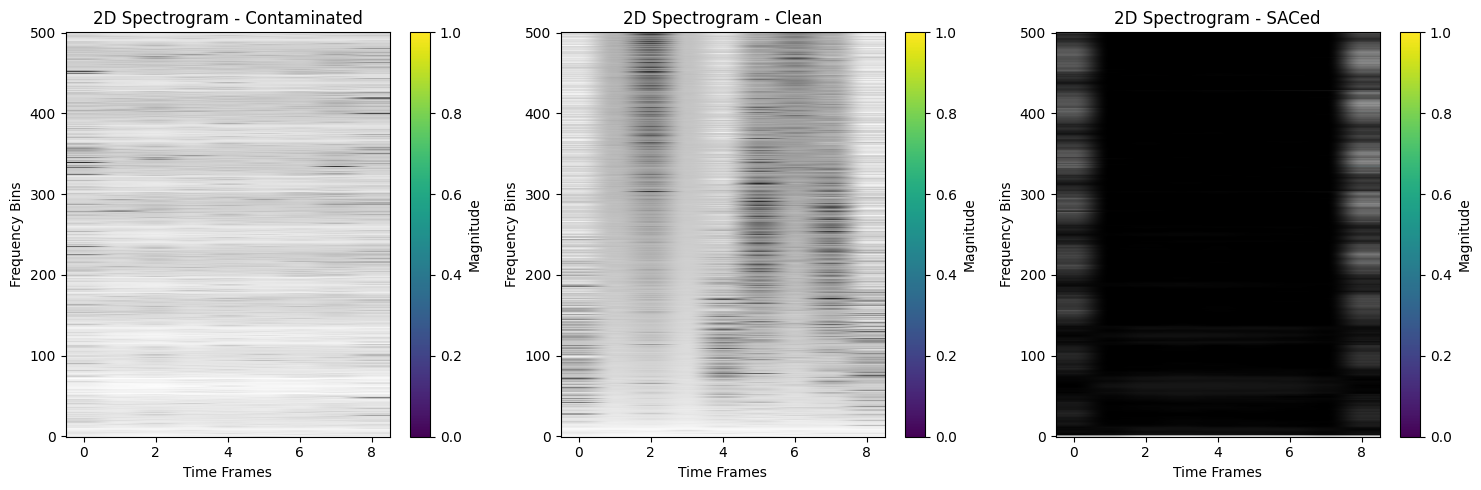

In [33]:
# test2
# 데이터 정규화 함수
def normalize(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    return (tensor - min_val) / (max_val - min_val)

# 첫 번째 샘플의 데이터를 시각화
sample_index = 0

# 첫 번째 샘플의 3채널 데이터를 시각화
contaminated_sample = normalize(Contaminated[sample_index, :, :, :]).permute(1, 2, 0).numpy()  # (501, 9, 3)
clean_sample = normalize(Clean[sample_index, :, :, :]).permute(1, 2, 0).numpy()  # (501, 9, 3)
saced_sample = normalize(SACed[sample_index, :, :, :]).permute(1, 2, 0).numpy()  # (501, 9, 3)

# 플롯 생성
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(contaminated_sample, aspect='auto', origin='lower')
plt.colorbar(label='Magnitude')
plt.title('2D Spectrogram - Contaminated')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.subplot(1, 3, 2)
plt.imshow(clean_sample, aspect='auto', origin='lower')
plt.colorbar(label='Magnitude')
plt.title('2D Spectrogram - Clean')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.subplot(1, 3, 3)
plt.imshow(saced_sample, aspect='auto', origin='lower')
plt.colorbar(label='Magnitude')
plt.title('2D Spectrogram - SACed')
plt.xlabel('Time Frames')
plt.ylabel('Frequency Bins')

plt.tight_layout()
plt.show()